In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv("../Fife-data/flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
targetColumns = list(df.columns[1:4]) + list(df.columns[5:19]) + list(df.columns[21:22])
load = df[targetColumns].iloc[7247:8687].values
data = np.ravel(load)

realLoads = np.empty((18,30,48))
for day in range(realLoads.shape[1]):
    for hour in range(realLoads.shape[2]):
        for feeder in range(realLoads.shape[0]):
            realLoads[feeder][day][hour] = data[day*realLoads.shape[0]*realLoads.shape[2] + hour*realLoads.shape[0] + feeder]


In [34]:
load_data = np.loadtxt("forecastData.txt")
filter_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)

In [35]:
load_data = np.loadtxt("scheduleData.txt")
schedule_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)

newLoad = np.empty((18,30,48))
SOC = np.empty((18,30,48))
chargeRate = np.empty((18,30,48))
for feeder in range(SOC.shape[0]):
    for day in range(SOC.shape[1]):
        for hour in range(SOC.shape[2]):
            newLoad[feeder][day][hour] = schedule_data[feeder*newLoad.shape[1] + day][5][hour]
            SOC[feeder][day][hour] = schedule_data[feeder*SOC.shape[1] + day][0][hour]
            chargeRate[feeder][day][hour] = schedule_data[feeder*SOC.shape[1] + day][1][hour] - schedule_data[feeder*SOC.shape[1] + day][2][hour] 

C:\Users\samta\AppData\Local\Temp\ipykernel_9272\3985870658.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


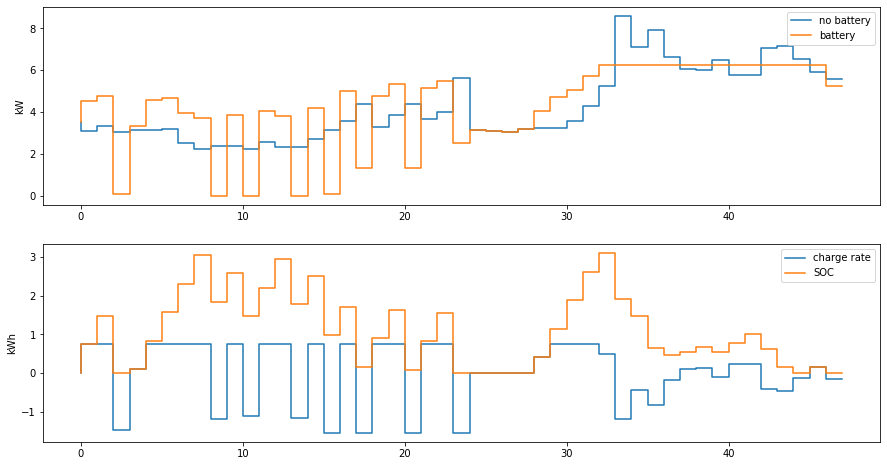

In [36]:
y = list(range(48))
fig, axs = plt.subplots(2)
axs[0].step(y,filter_data[0][1], label="no battery")
axs[0].step(y,newLoad[0][1], label="battery")
axs[0].legend()
axs[0].set_ylabel("kW")

axs[1].step(y,chargeRate[0][1], label="charge rate")
axs[1].step(y,SOC[0][1],label="SOC")
axs[1].legend()
axs[1].set_ylabel("kWh")


fig.set_figheight(8)
fig.set_figwidth(15)
fig.show()

In [37]:
load_data = np.loadtxt("forecastData.txt")
peakLoad = np.amax(load_data, axis=0)

class Battery:
    def __init__(self, maxLoad, chargeEfficiency=0.95, dischargeEfficiency=0.95):
        self.maxSOC = maxLoad * 0.25                    # in kWh
        self.maxChargeRate = (maxLoad * 0.25) / 2       # in kW
        self.maxDischargeRate = maxLoad * 0.25          # in kW
        self.chargeEfficiency = chargeEfficiency
        self.dischargeEfficiency = dischargeEfficiency


batteries = []
for i in range(filter_data.shape[0]):
    batteries.append(Battery(peakLoad[i]))

In [38]:
newSOC = np.empty((18,30,48))
newChargeRate = np.empty((18,30,48))
gridImport = np.empty((18,30,48))

for feeder in range(newSOC.shape[0]):
    for day in range(newSOC.shape[1]):
        for hour in range(newSOC.shape[2]):
            if hour == 0:
                newChargeRate[feeder][day][hour] = 0
                newSOC[feeder][day][hour] = 0
            else:
                newSOC[feeder][day][hour] = newSOC[feeder][day][hour-1] + chargeRate[feeder][day][hour]
                if newSOC[feeder][day][hour] > batteries[feeder].maxSOC:
                    # Assume extra charge is simply wasted
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour]
                    newSOC[feeder][day][hour] = batteries[feeder].maxSOC
                elif newSOC[feeder][day][hour] < 0:
                    # Charge less than zero must be accounted for
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour] - newSOC[feeder][day][hour]
                    newSOC[feeder][day][hour] = 0
                else:
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour]
            
            gridImport[feeder][day][hour] = realLoads[feeder][day][hour] + 2*newChargeRate[feeder][day][hour]


C:\Users\samta\AppData\Local\Temp\ipykernel_9272\468833166.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


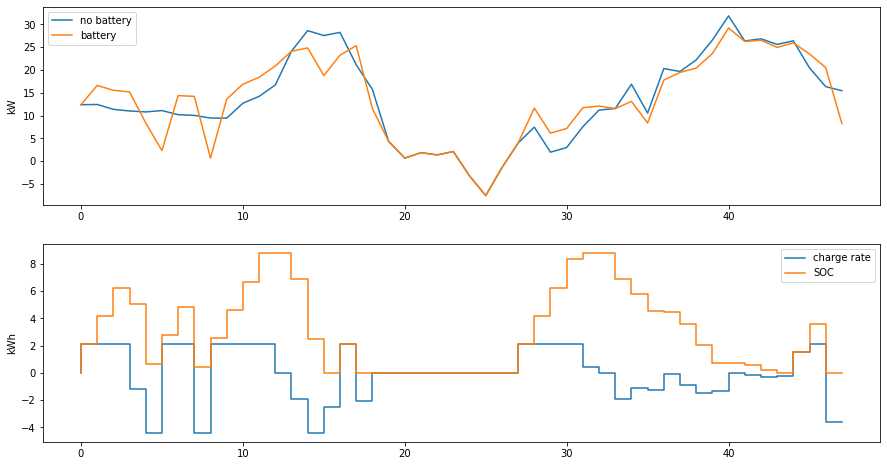

In [39]:
feeder = 6
day = 25

y = list(range(48))
fig, axs = plt.subplots(2)
axs[0].plot(y,realLoads[feeder][day], label="no battery")
axs[0].plot(y,gridImport[feeder][day], label="battery")
#axs[0].plot(y,filter_data[0][0], label="filter data")
axs[0].legend()
axs[0].set_ylabel("kW")

axs[1].step(y,newChargeRate[feeder][day], label="charge rate")
axs[1].step(y,newSOC[feeder][day],label="SOC")
axs[1].legend()
axs[1].set_ylabel("kWh")

fig.set_figheight(8)
fig.set_figwidth(15)
fig.show()

In [42]:
peakChangeRatio = []

for feeder in range(gridImport.shape[0]):
    realLoadsMax = []
    batteryLoadsMax = []
    for day in range(gridImport.shape[1]):
        realLoadsMax.append(max(realLoads[feeder][day]))
        batteryLoadsMax.append(max(gridImport[feeder][day]))
    peakChangeRatio.append(np.mean(np.divide(batteryLoadsMax, realLoadsMax)))

peakChangeRatio = np.asarray(peakChangeRatio)

# Value > 1 means peak is decreasing, < 1 means peak is increasing
percentageReduction = (1-peakChangeRatio) * 100
np.mean(percentageReduction)

2.3243855269442415

In [41]:
np.argmax(peakChangeRatio)
print(max(peakChangeRatio))

print(max(realLoads[3][25]) / max(gridImport[3][25]))

1.269397957661595
1.0
